In [2]:
#!/usr/bin/env python
# coding: utf-8

#import
import datasets
from toolbox import load_file, find_68_interval, models_dir
from constants import run_version, dataset_name, datapath, data_filename, label_filename, plots_dir, project_name, n_files, n_files_val, dataset_em, dataset_noise, test_file_ids, train_data_points, val_data_points, norm, epochs
from generator import Prepare_Dataset

import os
import numpy as np
import pickle
import argparse
from termcolor import colored
import time
from radiotools import helper as hp
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchviz import make_dot
#--------------------------------------------
# some constants
architectures_dir = "architectures"
learning_rate = 0.00005
es_patience = 8
es_min_delta = 0.0001 # Old value: es_min_delta = 0.0001
batchSize = 64
# ---------------------
epochs = 10
norm = 1e-6
train_data_points = 99900 #190000
val_data_points = 25000   #25000
test_data_points = 99900  #20000

In [2]:
# # Parse arguments
# parser = argparse.ArgumentParser(description='Neural network for neutrino energy reconstruction')
# parser.add_argument("run_id", type=str ,help="the id of the run, eg '3.2' for run3.2")
# args = parser.parse_args()
# run_id = args.run_id
run_id = "Model.5"
# Save the run name
run_name = f"run{run_id}"
# Make sure run_name is compatible with run_version
this_run_version = run_name.split(".")[0]
this_run_id = run_name.split(".")[1]
assert this_run_version == run_version, f"run_version ({run_version}) does not match the run version for this run ({this_run_version})"

# Models folder
saved_model_dir = models_dir(run_name)
# Make sure saved_models folder exists
if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)
# Make sure architectures folder exists
if not os.path.exists(f"{saved_model_dir}/{architectures_dir}"):
    os.makedirs(f"{saved_model_dir}/{architectures_dir}")
# Make sure plot dir exists
plots_dir=f"{plots_dir}/{run_id}"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

In [3]:
# Info for dataset
print("\ndatapath = ",datapath)
print("data_filename = ", data_filename)
print("label_filename = ", label_filename)

n_files_test = 3
n_files_train = n_files - n_files_val - n_files_test

list_of_file_ids_train = np.arange(n_files_train, dtype=int)
list_of_file_ids_val = np.arange(n_files_train, n_files_train + n_files_val, dtype=int)#np.int?
list_of_file_ids_test = np.arange(n_files_train + n_files_val, n_files, dtype=int)
n_events_per_file = 100000

print("\nTraining files #: ",list_of_file_ids_train)
print("Val files #: ",list_of_file_ids_val)
print("Test files #: ",list_of_file_ids_test)


datapath =  /mnt/md0/data/SouthPole/single_surface_4LPDA_PA_15m_RNOG_fullsim.json/ARZ2020_emhad_noise.yaml/G03generate_events_full_surface_sim/LPDA_2of4_100Hz/4LPDA_1dipole_fullband/em_had_separately/
data_filename =  data_had_emhad_1-3_had_1_LPDA_2of4_100Hz_4LPDA_1dipole_fullband_
label_filename =  labels_had_emhad_1-3_had_1_LPDA_2of4_100Hz_4LPDA_1dipole_fullband_

Training files #:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32]
Val files #:  [33 34 35 36 37]
Test files #:  [38 39 40]


In [4]:
# dataset
print("\nPreparing datasets...")

list_of_file_ids_train_small = np.random.choice(list_of_file_ids_train, size=33, replace=False)
print("Picked training set ids:",list_of_file_ids_train_small)
list_of_file_ids_val_small = np.random.choice(list_of_file_ids_val, size=1, replace=False)
print("Picked val set ids:",list_of_file_ids_val_small)

train = Prepare_Dataset(file_ids=list_of_file_ids_train_small,points = 3290000)
val = Prepare_Dataset(file_ids=list_of_file_ids_val_small, points = val_data_points)

# x_train, y_train = train[0]
# x_val, y_val = val[0]

# print(train, len(train), x_train.shape, y_train)
# print(val, len(val), x_val.shape, y_val)


Preparing datasets...
Picked training set ids: [29]
Picked val set ids: [37]
loading file 29
finished loading file 29 in 38.5605993270874s
Total train data points:  99999
loading file 37
finished loading file 37 in 9.914751052856445s
Total train data points:  99995


In [9]:
list_of_file_ids_train_small = np.random.choice(list_of_file_ids_train, size=33, replace=False)
train = Prepare_Dataset(file_ids=list_of_file_ids_train_small,points = 3299930)


loading file 29
finished loading file 29 in 9.800905704498291s
loading file 1
finished loading file 1 in 58.06258773803711s
loading file 11
finished loading file 11 in 63.70002222061157s
loading file 23
finished loading file 23 in 54.78714919090271s
loading file 18
finished loading file 18 in 56.996856927871704s
loading file 3
finished loading file 3 in 50.06057047843933s
loading file 10
finished loading file 10 in 62.67910718917847s
loading file 0
finished loading file 0 in 50.74393677711487s
loading file 5
finished loading file 5 in 108.92739772796631s
loading file 17
finished loading file 17 in 53.90181064605713s
loading file 20
finished loading file 20 in 45.3966748714447s
loading file 26
finished loading file 26 in 44.7163143157959s
loading file 7
finished loading file 7 in 43.39485430717468s
loading file 16
finished loading file 16 in 63.26037621498108s
loading file 24
finished loading file 24 in 60.04666757583618s
loading file 27
finished loading file 27 in 36.70982646942139s
lo

In [10]:
total_train_point = []
for x, y in train:
    total_train_point.append(y.item())


Text(0.5, 1.0, 'True Energy(Train data set, ARZ) ')

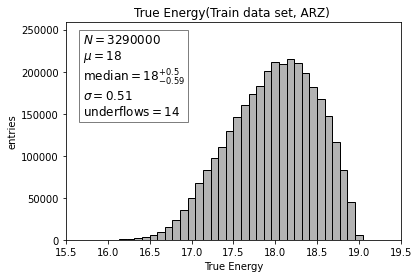

In [14]:
from radiotools import plthelpers as php
fig, ax = php.get_histogram(total_train_point, bins=np.linspace(15.5, 19.5, 45),  xlabel="True Energy")
plt.title(f"True Energy(Train data set, ARZ) ")
# fig.savefig(f"{plots_dir}/energy_resolution_{run_name}.png")

In [15]:
list_of_file_ids_val_small = np.random.choice(list_of_file_ids_val, size=5, replace=False)
val = Prepare_Dataset(file_ids=list_of_file_ids_val_small, points = 499980)


loading file 37
finished loading file 37 in 35.944965839385986s
loading file 34
finished loading file 34 in 11.507529020309448s
loading file 35
finished loading file 35 in 12.843443155288696s
loading file 33
finished loading file 33 in 11.746288061141968s
loading file 36
finished loading file 36 in 12.037865161895752s
Total train data points:  499982


In [16]:
total_val_point = []
for x, y in val:
    total_val_point.append(y.item())

Text(0.5, 1.0, 'True Energy(Val data set, ARZ) ')

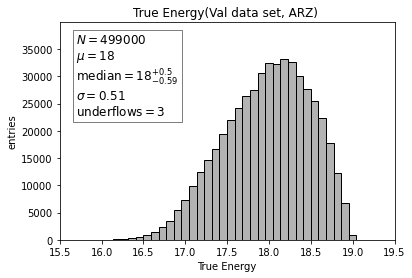

In [18]:
from radiotools import plthelpers as php
fig, ax = php.get_histogram(total_val_point, bins=np.linspace(15.5, 19.5, 45),  xlabel="True Energy")
plt.title(f"True Energy(Val data set, ARZ) ")
# fig.savefig(f"{plots_dir}/energy_resolution_{run_name}.png")

In [19]:
list_of_file_ids_test_small = np.random.choice(test_file_ids, size=3, replace=False)
test = Prepare_Dataset(file_ids=list_of_file_ids_test_small, points = 299990)#test_data_points)

loading file 40
finished loading file 40 in 35.57834815979004s
loading file 38
finished loading file 38 in 11.551552295684814s
loading file 39
finished loading file 39 in 11.523262023925781s
Total train data points:  299995


In [20]:
total_test_point = []
for x, y in test:
    total_test_point.append(y.item())

Text(0.5, 1.0, 'True Energy(Test data set, ARZ)')

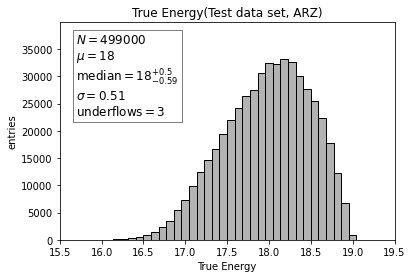

In [21]:
from radiotools import plthelpers as php
fig, ax = php.get_histogram(total_val_point, bins=np.linspace(15.5, 19.5, 45),  xlabel="True Energy")
plt.title(f"True Energy(Test data set, ARZ)")
# fig.savefig(f"{plots_dir}/energy_resolution_{run_name}.png")

Text(0.5, 1.0, 'True Energy(Total data set, ARZ)')

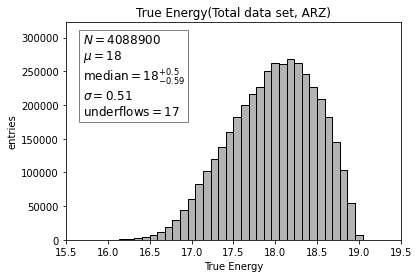

In [23]:
Total_dataset = total_train_point + total_val_point + total_test_point
fig, ax = php.get_histogram(Total_dataset, bins=np.linspace(15.5, 19.5, 45),  xlabel="True Energy")
plt.title(f"True Energy(Total data set, ARZ)")

In [5]:
# load data
from torch.utils.data import DataLoader
train_loader = DataLoader(train, batch_size=batchSize, shuffle=True, num_workers=64)
val_loader = DataLoader(val, batch_size=batchSize, shuffle=False, num_workers=64)
                               
# x, y = next(iter(train_loader))
# print(f"Feature batch shape: {x.size()}")
# print(f"Labels batch shape: {y.size()}")

In [6]:
# Model params
conv2D_filter_size = 5
pooling_size = 4
amount_Conv2D_layers_per_block = 3 
amount_Conv2D_blocks = 4
conv2D_filter_amount = 32

criterion = obj

In [7]:
# Create model using Pytorch Lightning 
from torch.optim.lr_scheduler import ReduceLROnPlateau 
import pytorch_lightning as pl
from torchsummary import summary
import jammy_flows

class E_Model(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn0 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(1, conv2D_filter_size), padding='same')
        self.cnn1 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, conv2D_filter_size), padding='same')
        
        self.cnn2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(1, conv2D_filter_size), padding='same')
        self.cnn2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, conv2D_filter_size), padding='same')

        self.cnn3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1, conv2D_filter_size), padding='same')
        self.cnn3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(1, conv2D_filter_size), padding='same')
        
        self.cnn4_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1, conv2D_filter_size), padding='same')
        self.cnn4_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(1, conv2D_filter_size), padding='same')

        self.avgpool = nn.AvgPool2d(kernel_size=(1, pooling_size))
        
        self.bn1 = nn.BatchNorm2d(256, eps = 0.001, momentum = 0.99, affine=True)
#         self.pdf = jammy_flows.pdf("e1", "gg", conditional_input_dim=2560, hidden_mlp_dims_sub_pdfs="1024-1024-512-256-128")
        self.pdf = jammy_flows.pdf("e1", "gg", conditional_input_dim=2560, hidden_mlp_dims_sub_pdfs="512-256-128")

    def forward(self, x):
        x = self.cnn0(x)
        x = torch.relu(x)
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.cnn1(x)
        x = torch.relu(x)
        x = self.avgpool(x)
        
        x = self.cnn2_1(x)
        x = torch.relu(x)
        x = self.cnn2_2(x)
        x = torch.relu(x)
        x = self.cnn2_2(x)
        x = torch.relu(x)
        x = self.avgpool(x)
        
        x = self.cnn3_1(x)
        x = torch.relu(x)
        x = self.cnn3_2(x)
        x = torch.relu(x)
        x = self.cnn3_2(x)
        x = torch.relu(x)
        x = self.avgpool(x)
        
        x = self.cnn4_1(x)
        x = torch.relu(x)
        x = self.cnn4_2(x)
        x = torch.relu(x)
        x = self.cnn4_2(x)
        x = torch.relu(x)
        x = self.avgpool(x)
        
        x = self.bn1(x)
        out =  torch.flatten(x, 1) #x.view(-1,2560) # torch.flatten(x, 1) ##
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate, eps=1e-7) 
        scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=es_patience-3, min_lr=0.000001, verbose=1)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        conv_out = self.forward(x)
#         print(torch.max(conv_out),torch.min(conv_out))
        log_pdf, _,_= self.pdf(y, conditional_input=conv_out)
        loss=-log_pdf.mean()
        self.log('train_loss', loss, prog_bar=True, on_epoch=True, logger=True, on_step=False)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        conv_out = self.forward(x)
        log_pdf, _,_= self.pdf(y, conditional_input=conv_out)
        loss=-log_pdf.mean()
        self.log('val_loss', loss, prog_bar=True, on_epoch = True, logger=True)

# create a model
model = E_Model()
model.double()

E_Model(
  (cnn0): Conv2d(1, 32, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn1): Conv2d(32, 32, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn2_1): Conv2d(32, 64, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn2_2): Conv2d(64, 64, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn3_1): Conv2d(64, 128, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn3_2): Conv2d(128, 128, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn4_1): Conv2d(128, 256, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (cnn4_2): Conv2d(256, 256, kernel_size=(1, 5), stride=(1, 1), padding=same)
  (avgpool): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
  (bn1): BatchNorm2d(256, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
  (pdf): pdf(
    (layer_list): ModuleList(
      (0): ModuleList(
        (0): gf_block()
        (1): gf_block()
      )
    )
    (mlp_predictors): ModuleList(
      (0): Sequential(
        (0): Linear(in_features=256

In [8]:
os.system(f"python print_model.py")
# Sleep for a few seconds to free up some resources...
time.sleep(1)

#  x, y = next(iter(train_loader))
#  model.pdf.init_params(data=y)

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.xavier_uniform_(m.weight.data)
#         torch.nn.init.zeros_(m.bias.data)
#     if isinstance(m, nn.Linear):
#         nn.init.xavier_uniform_(m.weight.data)
#         torch.nn.init.zeros_(m.bias.data)
# model.apply(weights_init)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 5, 512]             192
            Conv2d-2           [-1, 32, 5, 512]           5,152
            Conv2d-3           [-1, 32, 5, 512]           5,152
         AvgPool2d-4           [-1, 32, 5, 128]               0
            Conv2d-5           [-1, 64, 5, 128]          10,304
            Conv2d-6           [-1, 64, 5, 128]          20,544
            Conv2d-7           [-1, 64, 5, 128]          20,544
         AvgPool2d-8            [-1, 64, 5, 32]               0
            Conv2d-9           [-1, 128, 5, 32]          41,088
           Conv2d-10           [-1, 128, 5, 32]          82,048
           Conv2d-11           [-1, 128, 5, 32]          82,048
        AvgPool2d-12            [-1, 128, 5, 8]               0
           Conv2d-13            [-1, 256, 5, 8]         164,096
           Conv2d-14            [-1, 25

In [9]:
#callback
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import DeviceStatsMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import Callback

mc = ModelCheckpoint(dirpath=saved_model_dir, filename= "latest_model_checkpoint", 
    monitor='val_loss', verbose=1)

es = EarlyStopping("val_loss", patience=es_patience, min_delta=es_min_delta, verbose=1)

class MyPrintingCallback(Callback):
    def on_train_start(self, trainer, pl_module):
        print("Training is starting")
#         x, y = next(iter(train_loader))
#         model.pdf.init_params(data=y)
    
callbacks = [es, mc, MyPrintingCallback()] # DeviceStatsMonitor()

# Configuring CSV-logger : save epoch and loss values
csv_logger = CSVLogger(saved_model_dir, version=0)#, flush_logs_every_n_steps=64)#, append=True)

In [12]:
# training
trainer = pl.Trainer(
    gpus=1, 
    auto_select_gpus=True,
#     accelerator="gpu", 
#     devices=[2],
    callbacks = callbacks, 
    max_epochs = epochs,
    logger = csv_logger,
    precision = 32,
    num_sanity_val_steps=0
    )
    # profiler="simple",#how long a function takes or how much memory is used.
 

Auto select gpus: [0]
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [13]:
try:
    trainer.fit(model, train_loader, val_loader)
except: 
    trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name    | Type        | Params
-----------------------------------------
0  | cnn0    | Conv2d      | 192   
1  | cnn1    | Conv2d      | 5.2 K 
2  | cnn2_1  | Conv2d      | 10.3 K
3  | cnn2_2  | Conv2d      | 20.5 K
4  | cnn3_1  | Conv2d      | 41.1 K
5  | cnn3_2  | Conv2d      | 82.0 K
6  | cnn4_1  | Conv2d      | 164 K 
7  | cnn4_2  | Conv2d      | 327 K 
8  | avgpool | AvgPool2d   | 0     
9  | bn1     | BatchNorm2d | 512   
10 | pdf     | pdf         | 1.5 M 
-----------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.542     Total estimated model params size (MB)


Training is starting


Training: 0it [00:00, ?it/s]

/software/anaconda3/envs/pytorch/lib/python3.9/site-packages/torch/distributions/normal.py:85: UserWarning: Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /home/ting/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646756402876/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)
  return self.loc + self.scale * torch.erfinv(2 * value - 1) * math.sqrt(2)
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name    | Type        | Params
-----------------------------------------
0  | cnn0    | Conv2d      | 192   
1  | cnn1    | Conv2d      | 5.2 K 
2  | cnn2_1  | Conv2d      | 10.3 K
3  | cnn2_2  | Conv2d      | 20.5 K
4  | cnn3_1  | Conv2d      | 41.1 K
5  | cnn3_2  | Conv2d      | 82.0 K
6  | cnn4_1  | Conv2d      | 164 K 
7  | cnn4_2  | Conv2d      | 327 K 
8  | avgpool | AvgPool2d   | 0     
9  | bn1     | BatchNorm2d | 512   
10 | pdf     | pdf    

Training is starting


Training: 0it [00:00, ?it/s]

In [ ]:
# Save the model (for opening in eg Netron)
save_model_path=os.path.join(saved_model_dir, f"{run_name}.pt")
torch.save(model.state_dict(), save_model_path)